## Imports

In [1]:
import os
import json

from ast import literal_eval

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

import nltk
from nltk.corpus import (stopwords, words)
from nltk.stem.porter import PorterStemmer

from polyglot.detect import Detector
from polyglot.detect.base import logger as polyglot_logger
polyglot_logger.setLevel("ERROR")
import icu

from top2vec import Top2Vec

from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer)

## Constants

In [2]:
PROCESSED_DIR = '../data/processed'
PROCESSED_PATH = os.path.join(PROCESSED_DIR, 'wiki_edits.csv')

In [3]:
TEXT_COLS = ['page_title', 'parsed_summary', 'section', 'summary']

## Utilities

In [4]:
def remove_username(text, username):
    return str(text).replace(str(username), '')
def remove_digits(text):
    return ''.join([i for i in str(text) if not i.isdigit()])
def remove_typos(text):
    return ''.join([i for i in str(text) if i in words.words()])

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return str(text).translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

## Load data

In [5]:
data = pd.read_csv(
    PROCESSED_PATH,
    converters={"hashtags": literal_eval, "mentions": literal_eval}
)

data.head()

action  change_size flags hashtags  is_anon  is_bot  is_minor  is_new  \
0   edit       1441.0   NaN       []    False   False     False   False   
1   edit          2.0   NaN       []    False   False     False   False   
2   edit         11.0    MB       []    False    True      True   False   
3   edit         -6.0     M       []    False   False      True   False   
4   edit          4.0     M       []    False   False      True   False   

   is_unpatrolled mentions         ns                          page_title  \
0           False       []       User         User:Bluesymamal417/sandbox   
1           False       []       Main            List of NAIA conferences   
2           False       []  User talk              User talk:76.64.60.162   
3           False       []       Main                  Conrad Kennedy III   
4           False       []   Template  Template:2011–12 in Greek football   

   parent_rev_id                                     parsed_summary  \
0   1.077812e+09                                                NaN   
1   1.077812e+09                                                NaN   
2   1.077812e+09  Fixed [[WP:LINT|Lint errors]]. ([[User:Malnada...   
3   1.077812e+09  v2.04b - Fix errors for [[WP:WCW|CW project]] ...   
4   1.077812e+09                                                NaN   

         rev_id section                                            summary  \
0  1.077293e+09     NaN                                                NaN   
1  1.077812e+09     NaN                                                NaN   
2  4.273666e+08     NaN  Fixed [[WP:LINT|Lint errors]]. ([[User:Malnada...   
3  1.073852e+09     NaN  v2.04b - Fix errors for [[WP:WCW|CW project]] ...   
4  1.077812e+09     NaN                                                NaN   

                                                 url              user geo_ip  
0  https://en.wikipedia.org/w/index.php?diff=1077...    Bluesymamal417    NaN  
1  https://en.wikipedia.org/w/index.php?diff=1077...  Santiago Claudio    NaN  
2  https://en.wikipedia.org/w/index.php?diff=1077...      MalnadachBot    NaN  
3  https://en.wikipedia.org/w/index.php?diff=1077...           ZI Jony    NaN  
4  https://en.wikipedia.org/w/index.php?diff=1077...            BEN917    NaN

## Language detection

In [6]:
def detect_language(text):
    detector = Detector(text, quiet = True)
    language = icu.Locale.getDisplayName(detector.language.locale)
    return language

In [7]:
data['language'] = data['page_title'].apply(lambda x: detect_language(x))

In [8]:
data['language'].value_counts().head()

English    146830
un           3817
Danish       1797
Malay        1049
Latin         974
Name: language, dtype: int64

## Text preprocessing

In [9]:
for text_col in TEXT_COLS:
    data[text_col+'_preprocessed'] = data[text_col]
    
data.head()

action  change_size flags hashtags  is_anon  is_bot  is_minor  is_new  \
0   edit       1441.0   NaN       []    False   False     False   False   
1   edit          2.0   NaN       []    False   False     False   False   
2   edit         11.0    MB       []    False    True      True   False   
3   edit         -6.0     M       []    False   False      True   False   
4   edit          4.0     M       []    False   False      True   False   

   is_unpatrolled mentions  ... section  \
0           False       []  ...     NaN   
1           False       []  ...     NaN   
2           False       []  ...     NaN   
3           False       []  ...     NaN   
4           False       []  ...     NaN   

                                             summary  \
0                                                NaN   
1                                                NaN   
2  Fixed [[WP:LINT|Lint errors]]. ([[User:Malnada...   
3  v2.04b - Fix errors for [[WP:WCW|CW project]] ...   
4                                                NaN   

                                                 url              user  \
0  https://en.wikipedia.org/w/index.php?diff=1077...    Bluesymamal417   
1  https://en.wikipedia.org/w/index.php?diff=1077...  Santiago Claudio   
2  https://en.wikipedia.org/w/index.php?diff=1077...      MalnadachBot   
3  https://en.wikipedia.org/w/index.php?diff=1077...           ZI Jony   
4  https://en.wikipedia.org/w/index.php?diff=1077...            BEN917   

   geo_ip language             page_title_preprocessed  \
0     NaN  English         User:Bluesymamal417/sandbox   
1     NaN  English            List of NAIA conferences   
2     NaN  English              User talk:76.64.60.162   
3     NaN  English                  Conrad Kennedy III   
4     NaN  English  Template:2011–12 in Greek football   

                         parsed_summary_preprocessed section_preprocessed  \
0                                                NaN                  NaN   
1                                                NaN                  NaN   
2  Fixed [[WP:LINT|Lint errors]]. ([[User:Malnada...                  NaN   
3  v2.04b - Fix errors for [[WP:WCW|CW project]] ...                  NaN   
4                                                NaN                  NaN   

                                summary_preprocessed  
0                                                NaN  
1                                                NaN  
2  Fixed [[WP:LINT|Lint errors]]. ([[User:Malnada...  
3  v2.04b - Fix errors for [[WP:WCW|CW project]] ...  
4                                                NaN  

[5 rows x 25 columns]

In [10]:
for text_col in TEXT_COLS:
    data[text_col+'_preprocessed'] = data.apply(lambda x: remove_username(x[text_col+'_preprocessed'], x['user']), axis = 1)
    data[text_col+'_preprocessed'] = data[text_col+'_preprocessed'].apply(lambda text: remove_digits(text))
    data[text_col+'_preprocessed'] = data[text_col+'_preprocessed'].str.lower()
#     data[text_col+'_preprocessed'] = data[text_col+'_preprocessed'].apply(lambda text: remove_typos(text))
    data[text_col+'_preprocessed'] = data[text_col+'_preprocessed'].apply(lambda text: remove_punctuation(text))
    data[text_col+'_preprocessed'] = data[text_col+'_preprocessed'].apply(lambda text: remove_stopwords(text))
    data[text_col+'_preprocessed'] = data[text_col+'_preprocessed'].apply(lambda text: stem_words(text))
    

In [11]:
data['page_title_preprocessed'].head()

0                usersandbox
1           list naia confer
2                  user talk
3         conrad kennedi iii
4    template– greek footbal
Name: page_title_preprocessed, dtype: object

### CountVectorizer

In [12]:
document = data['page_title_preprocessed'].values.tolist()

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(document)

In [14]:
data['text_length'] = data["page_title"].str.split().map(len)

In [15]:
word_count = pd.DataFrame({'words': vectorizer.get_feature_names_out(), 
             'counts': np.asarray(X.sum(axis = 0).flatten())[0]})

word_count.head()

words  counts
0           aa      11
1          aaa       3
2         aaaa       1
3  aaaaaarchiv       1
4       aachen       1

In [16]:
word_count.sort_values(by = 'counts')[-40:]

words  counts
11818                       de     822
46433  speciallogpagetriagecur     830
25940                     john     835
35284                      new     869
72717                      war     880
38103                    peopl     891
46430            speciallogmov     900
68867                       tv     934
73483     wikipediawikiproject    1006
46441          speciallogthank    1053
19338                     game    1066
45901                     song    1080
46435         speciallogpatrol    1086
29286                    leagu    1141
4354                 basketbal    1143
17450                       fc    1153
8679              championship    1164
43822                   school    1169
66357                     team    1219
44365                     seri    1226
46429          speciallogdelet    1256
73303          wikipediaarticl    1261
46839                  station    1300
34917                   nation    1395
73860                    world    1462
3113                    athlet    1573
73770                    women    1579
32573                      men    1733
69244                     unit    1752
18585                  footbal    1885
46791                    state    2106
18174                     film    2227
44039                   season    2286
71028              usersandbox    2874
46431          speciallognewus    2975
46428          speciallogblock    4334
46427      speciallogabusefilt    5825
48357                     talk    7669
29912                     list    9524
69423                     user   27113

### Top2Vec

In [17]:
model = Top2Vec(document)

print(f'Number of topics found:  {model.get_num_topics()}')

2022-03-20 23:05:13,627 - top2vec - INFO - Pre-processing documents for training
2022-03-20 23:05:15,710 - top2vec - INFO - Creating joint document/word embedding
2022-03-20 23:10:00,081 - top2vec - INFO - Creating lower dimension embedding of documents
2022-03-20 23:12:01,358 - top2vec - INFO - Finding dense areas of documents
2022-03-20 23:12:11,578 - top2vec - INFO - Finding topics


Number of topics found:  82


In [18]:
model.hierarchical_topic_reduction(10)

[[59,
  55,
  53,
  75,
  46,
  30,
  41,
  63,
  58,
  73,
  65,
  31,
  40,
  74,
  54,
  32,
  76,
  80,
  19,
  2],
 [48, 50, 14, 9, 42, 81, 66, 69, 18, 52, 27, 79, 11],
 [71, 12, 21, 6, 45, 35, 62, 36, 49, 28, 4],
 [43, 34, 20, 77, 57, 47, 25, 23, 16, 24, 13],
 [44, 37, 3],
 [67, 78, 72, 7, 33, 5],
 [56, 17, 10],
 [0],
 [64, 60, 70, 51, 61, 8, 29, 68, 26, 39, 15],
 [22, 38, 1]]

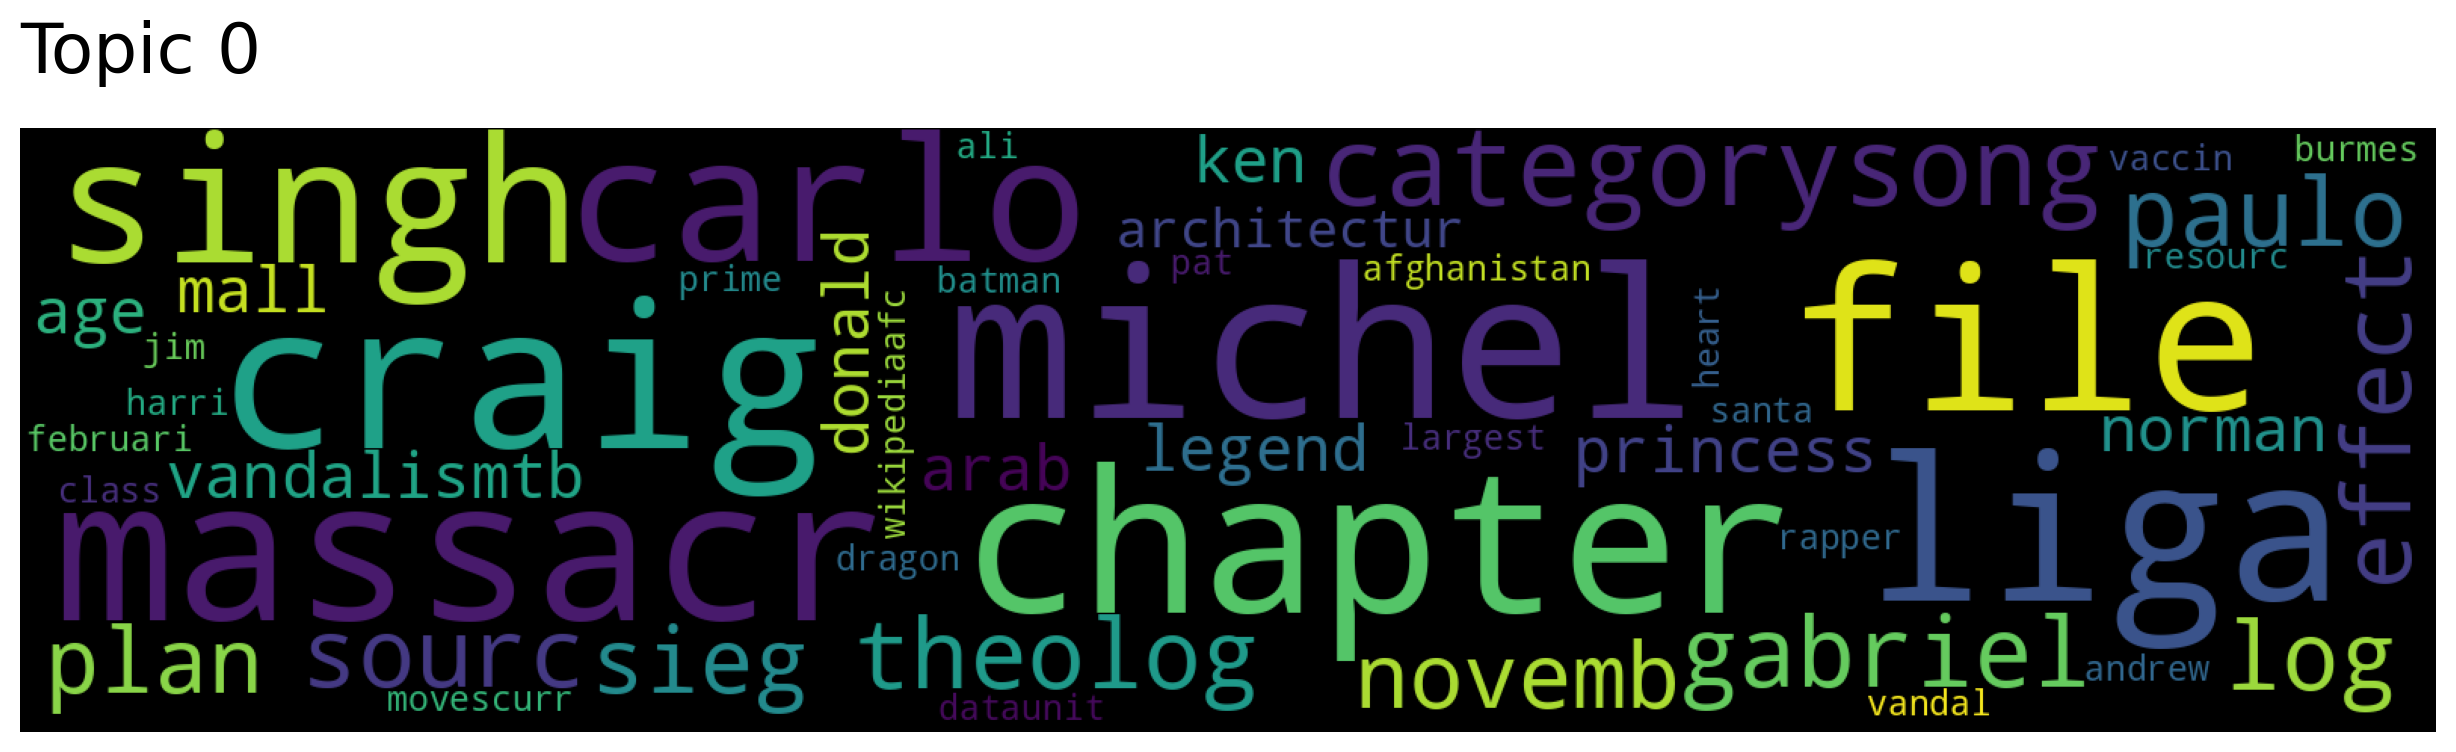

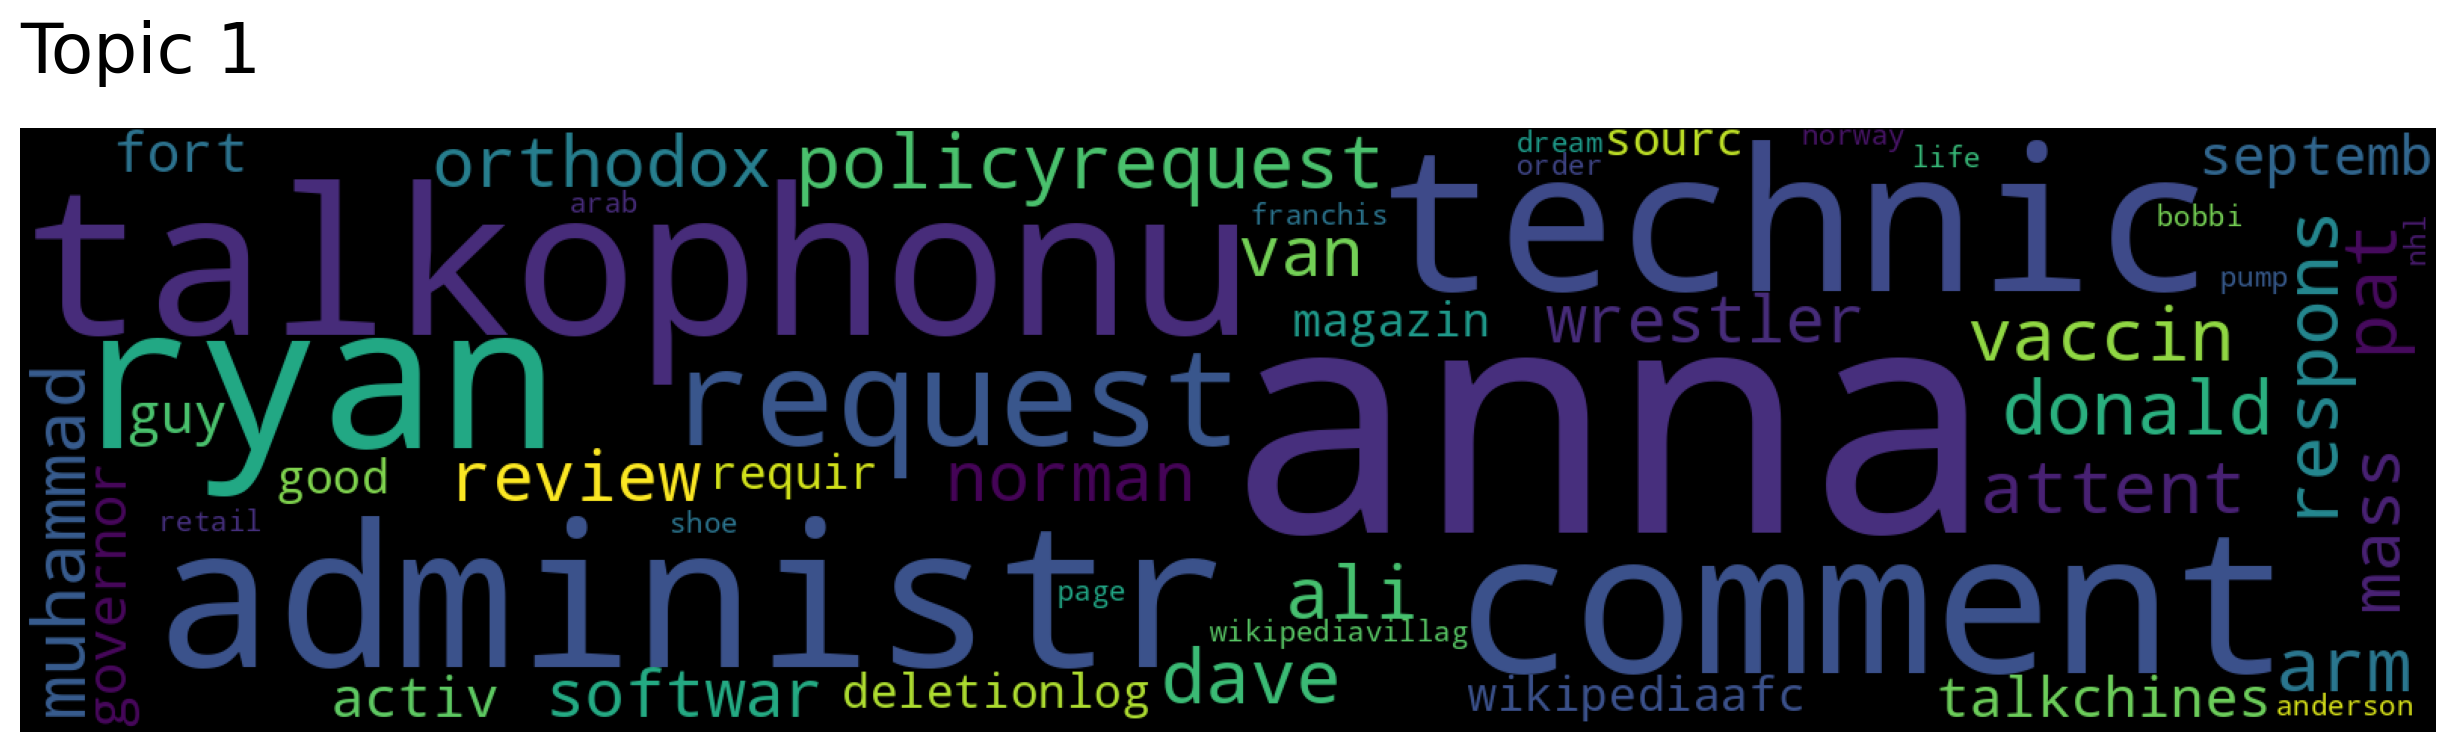

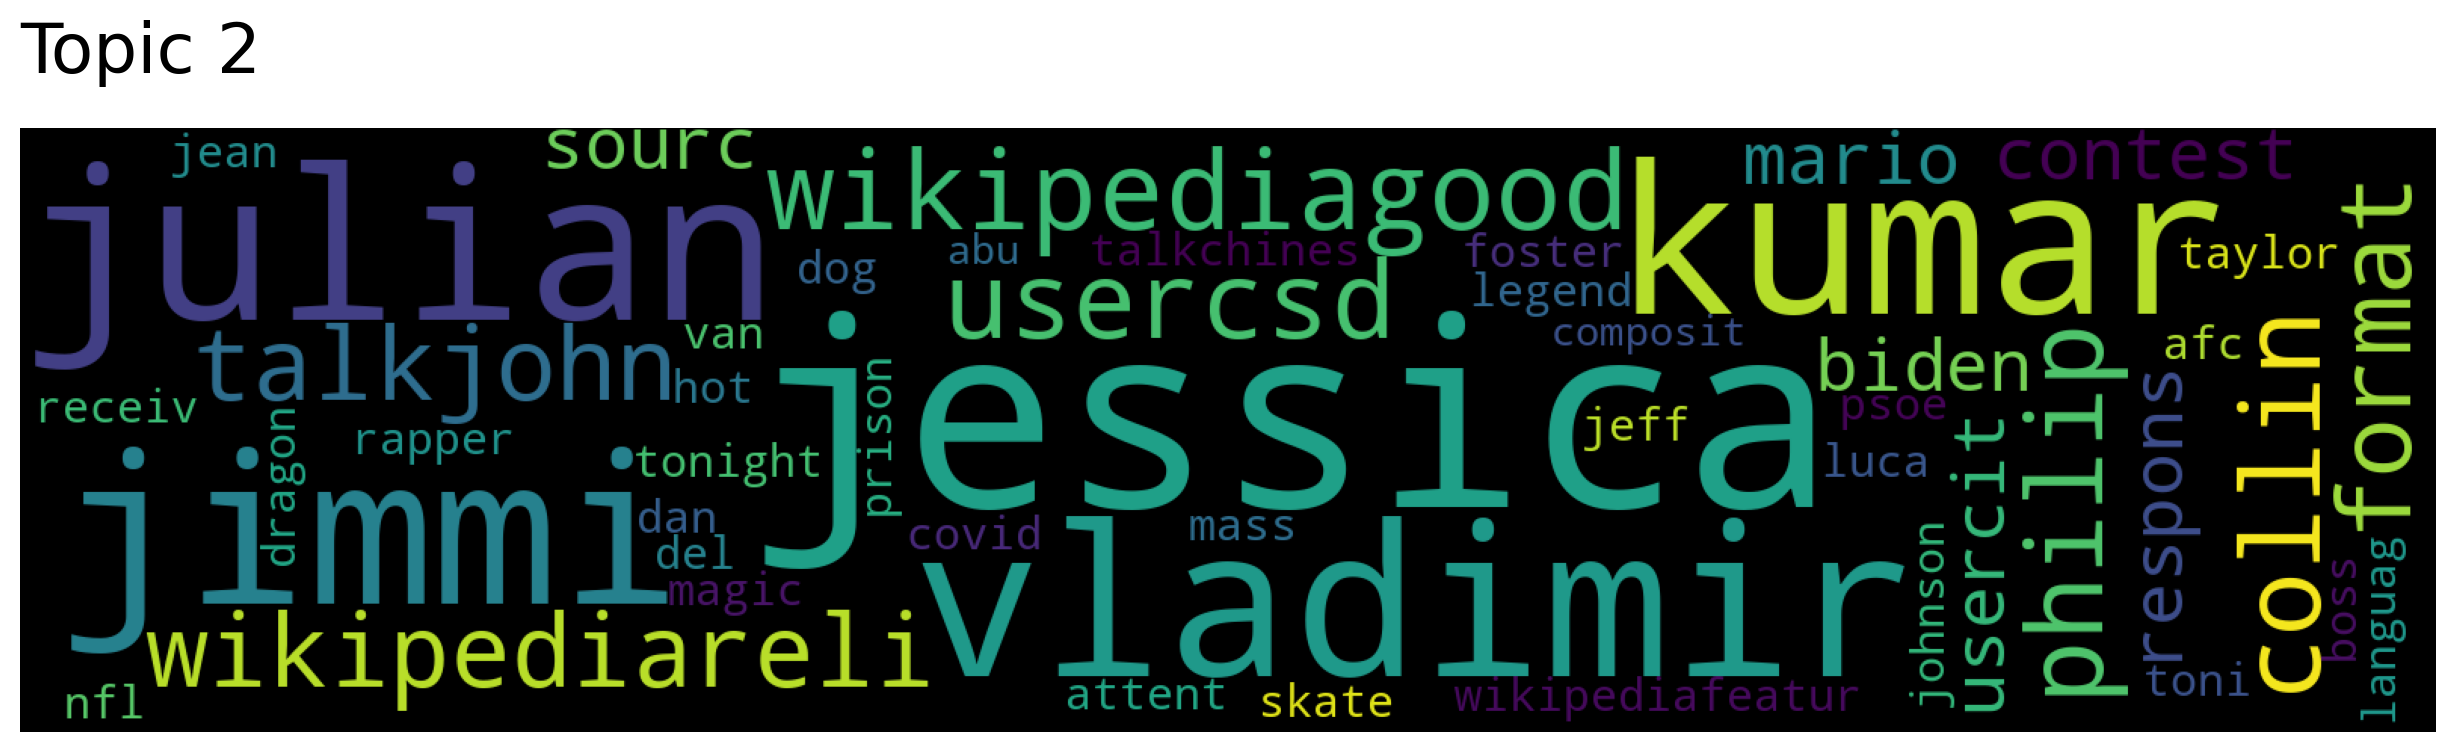

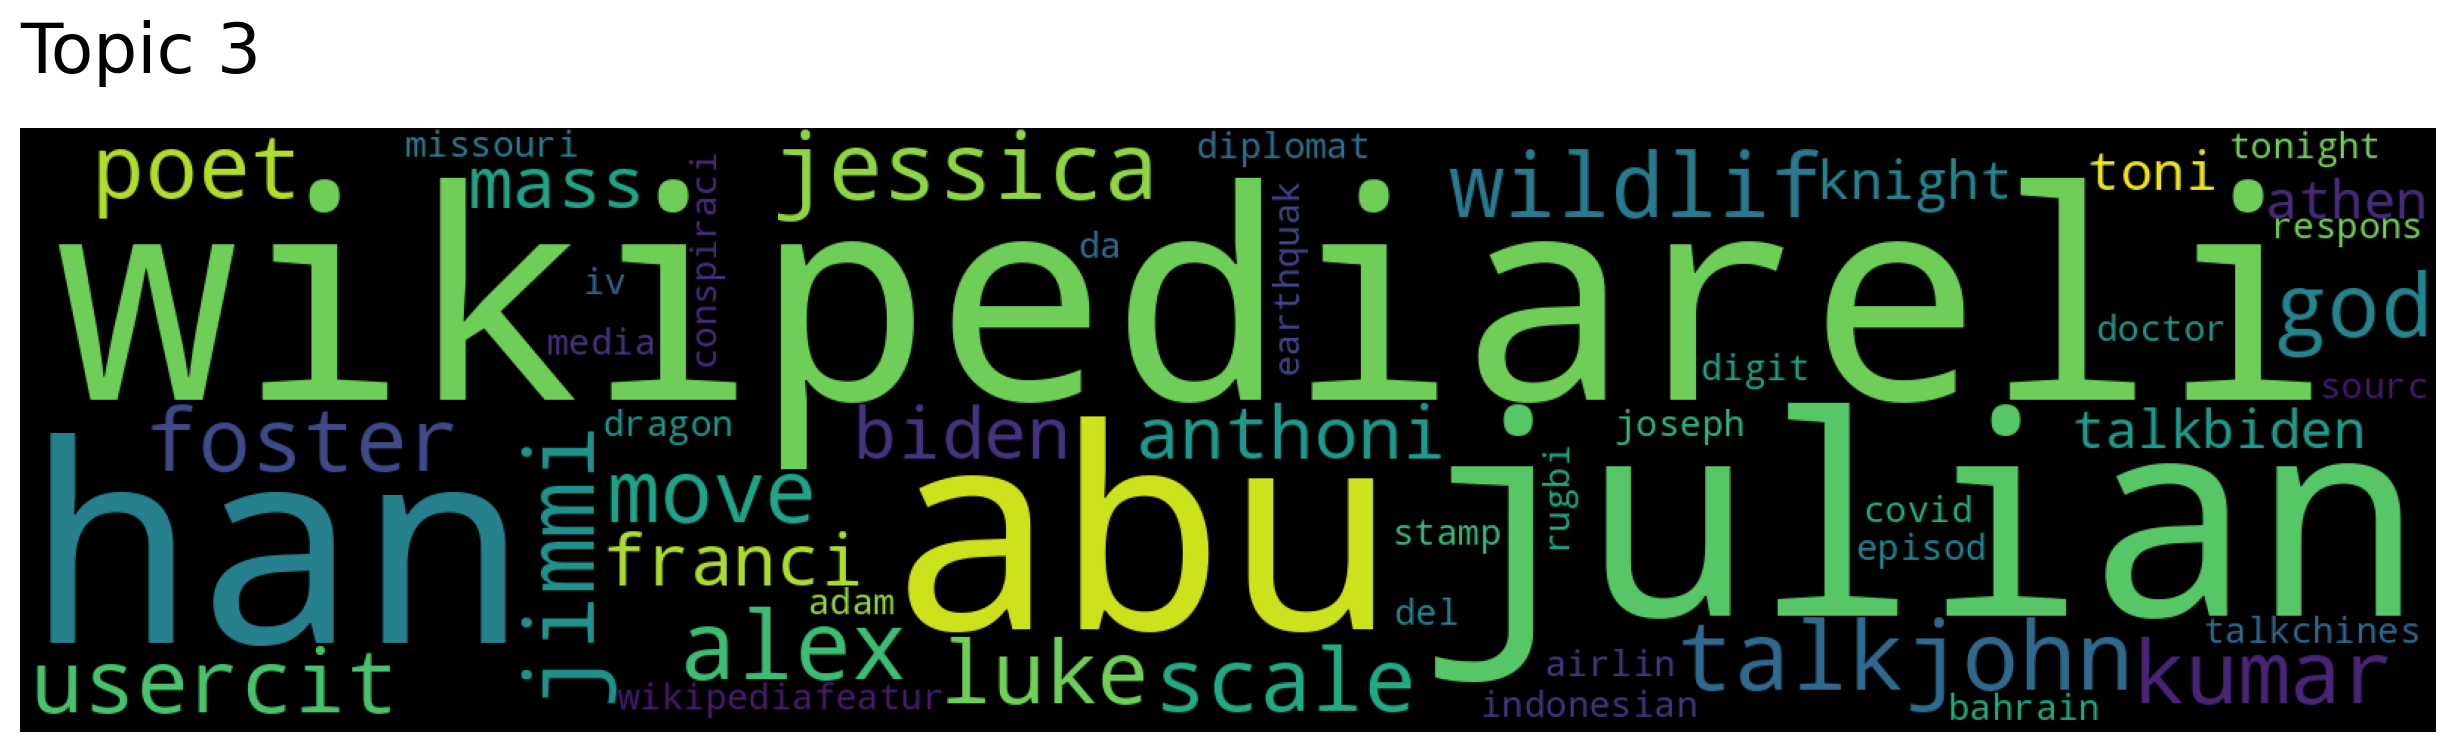

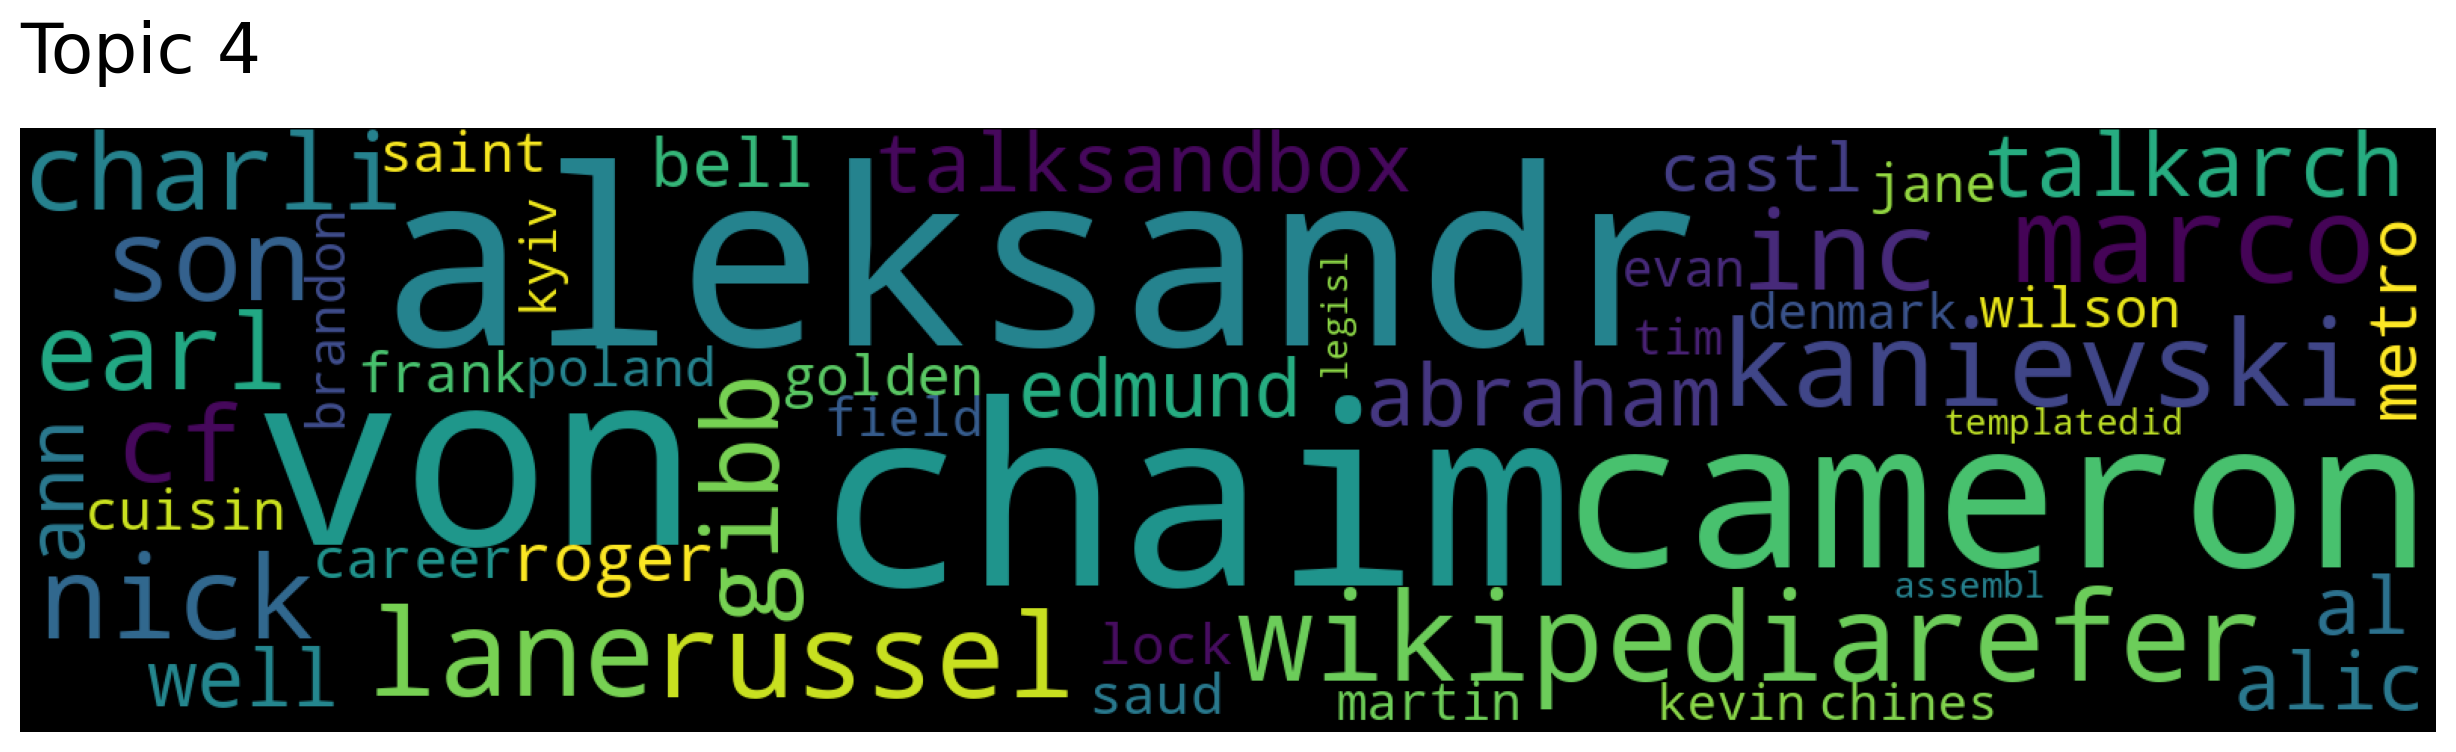

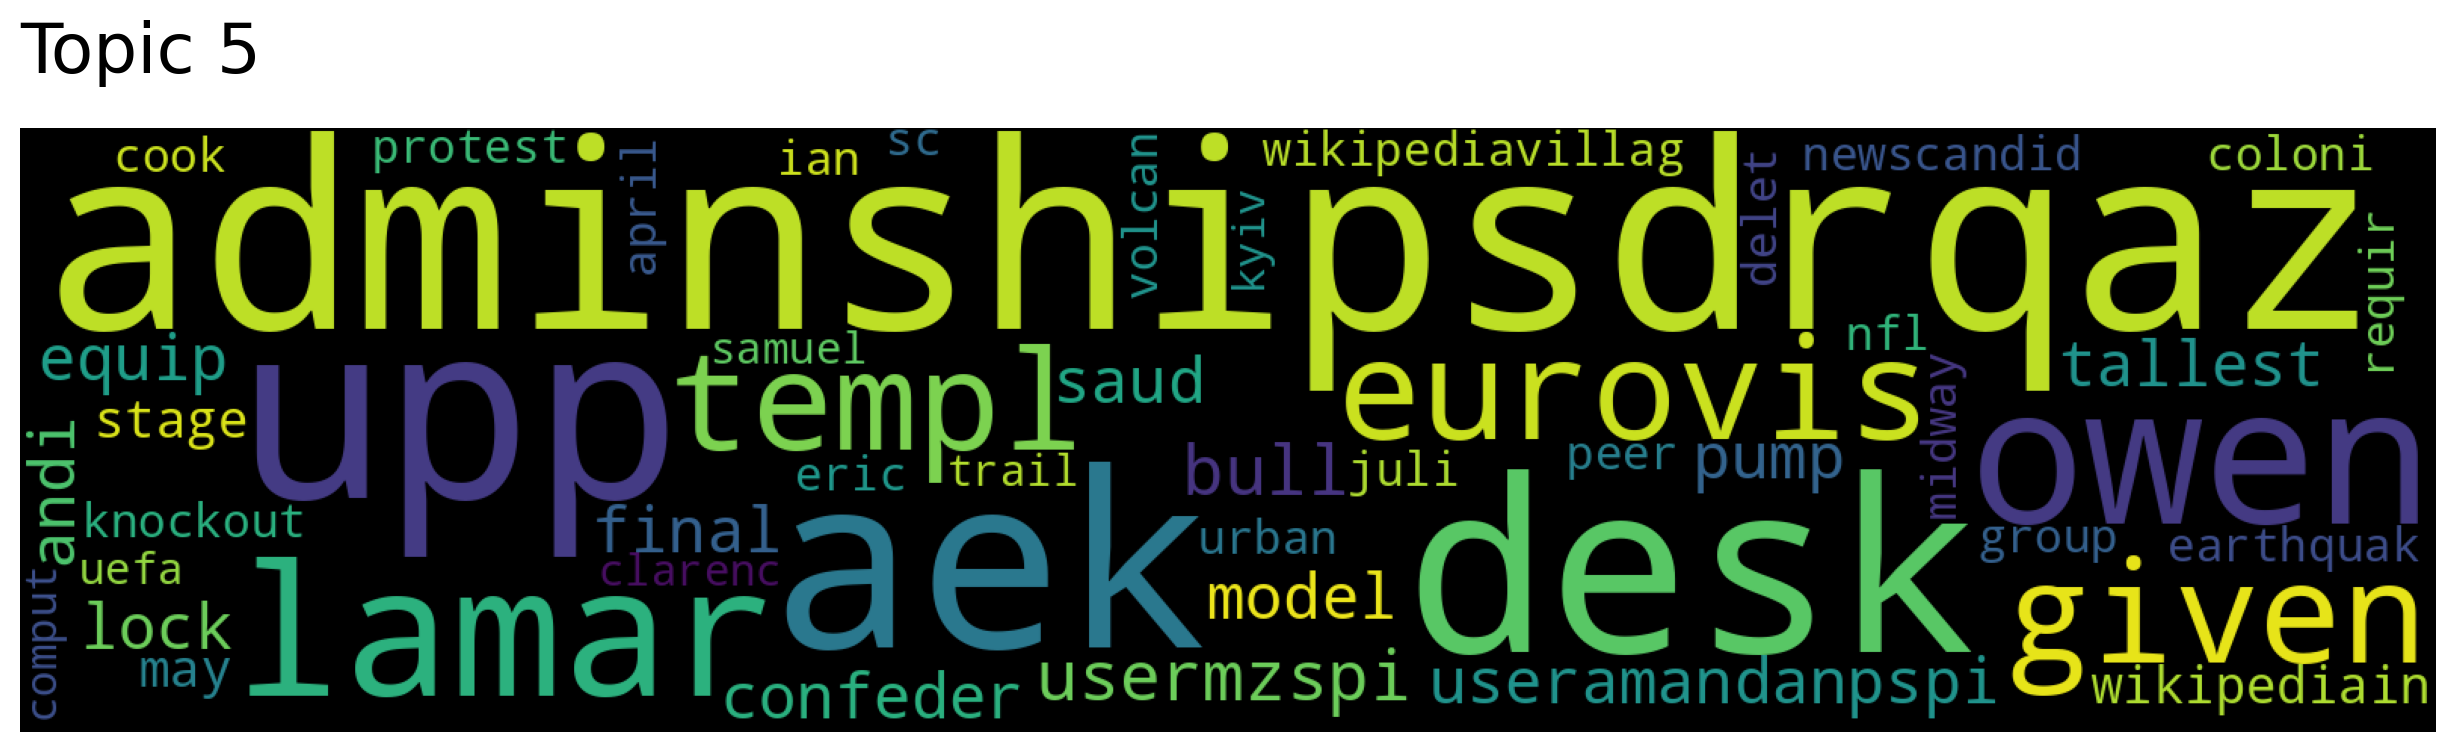

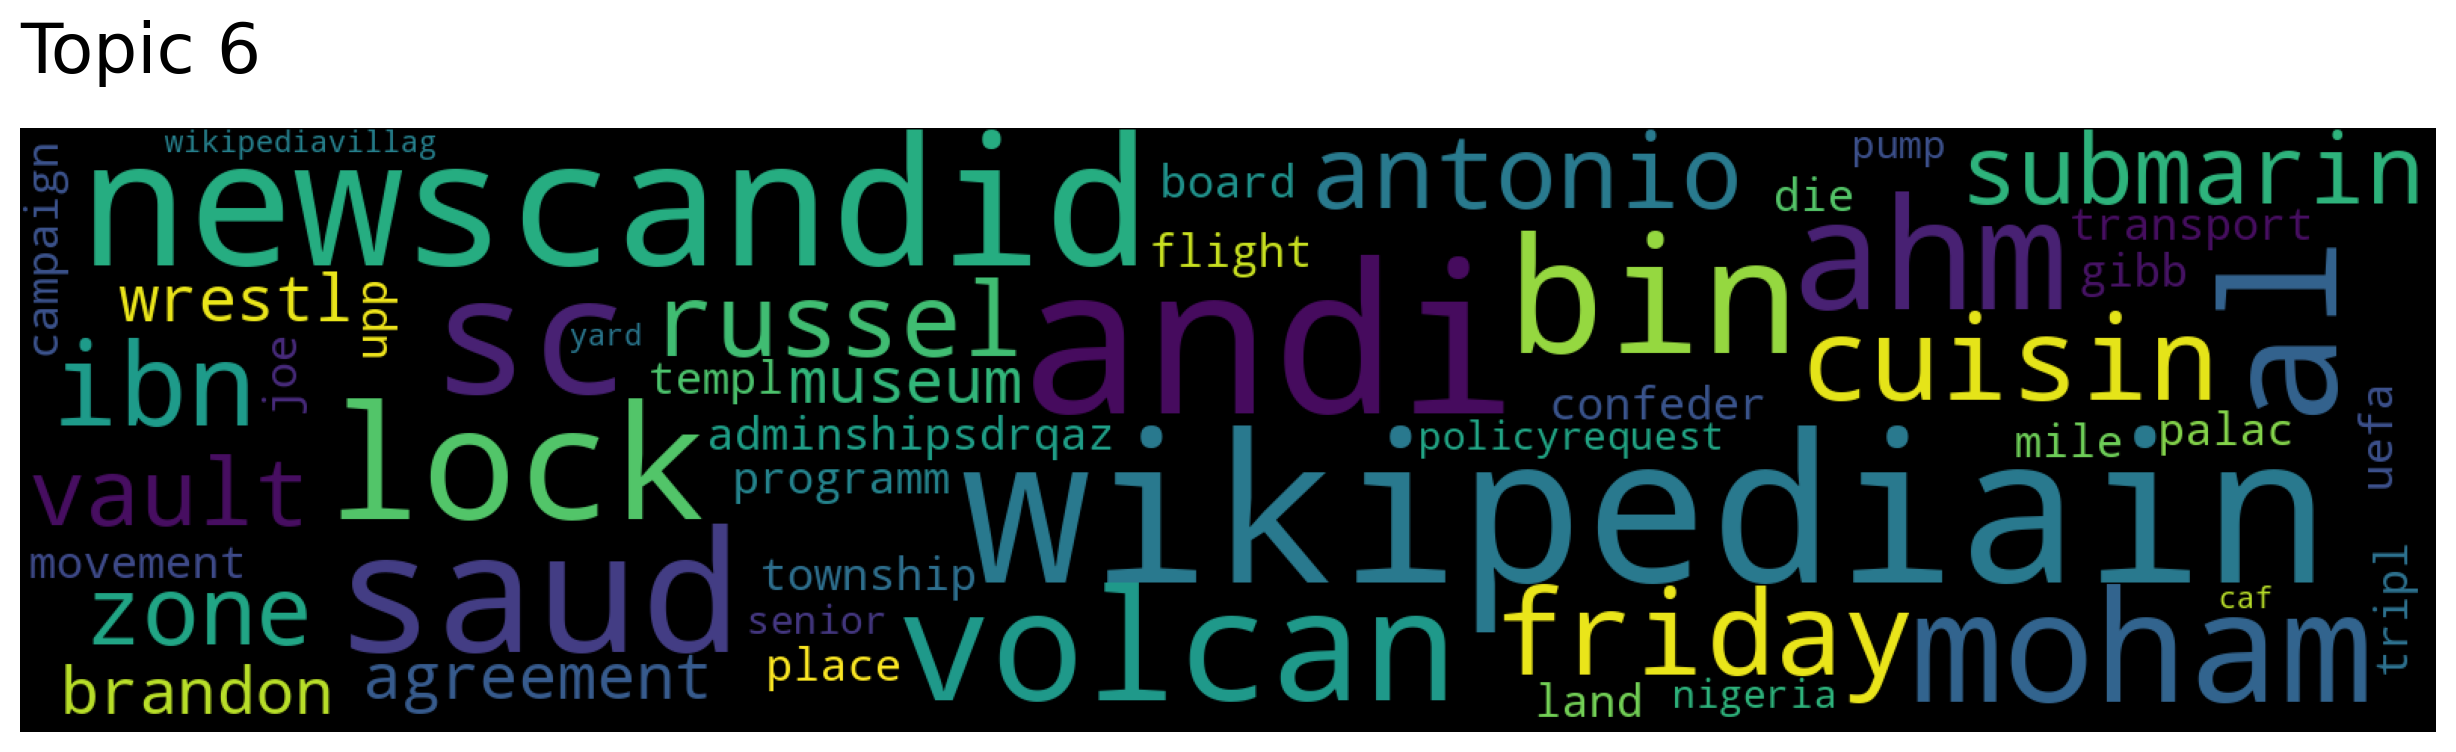

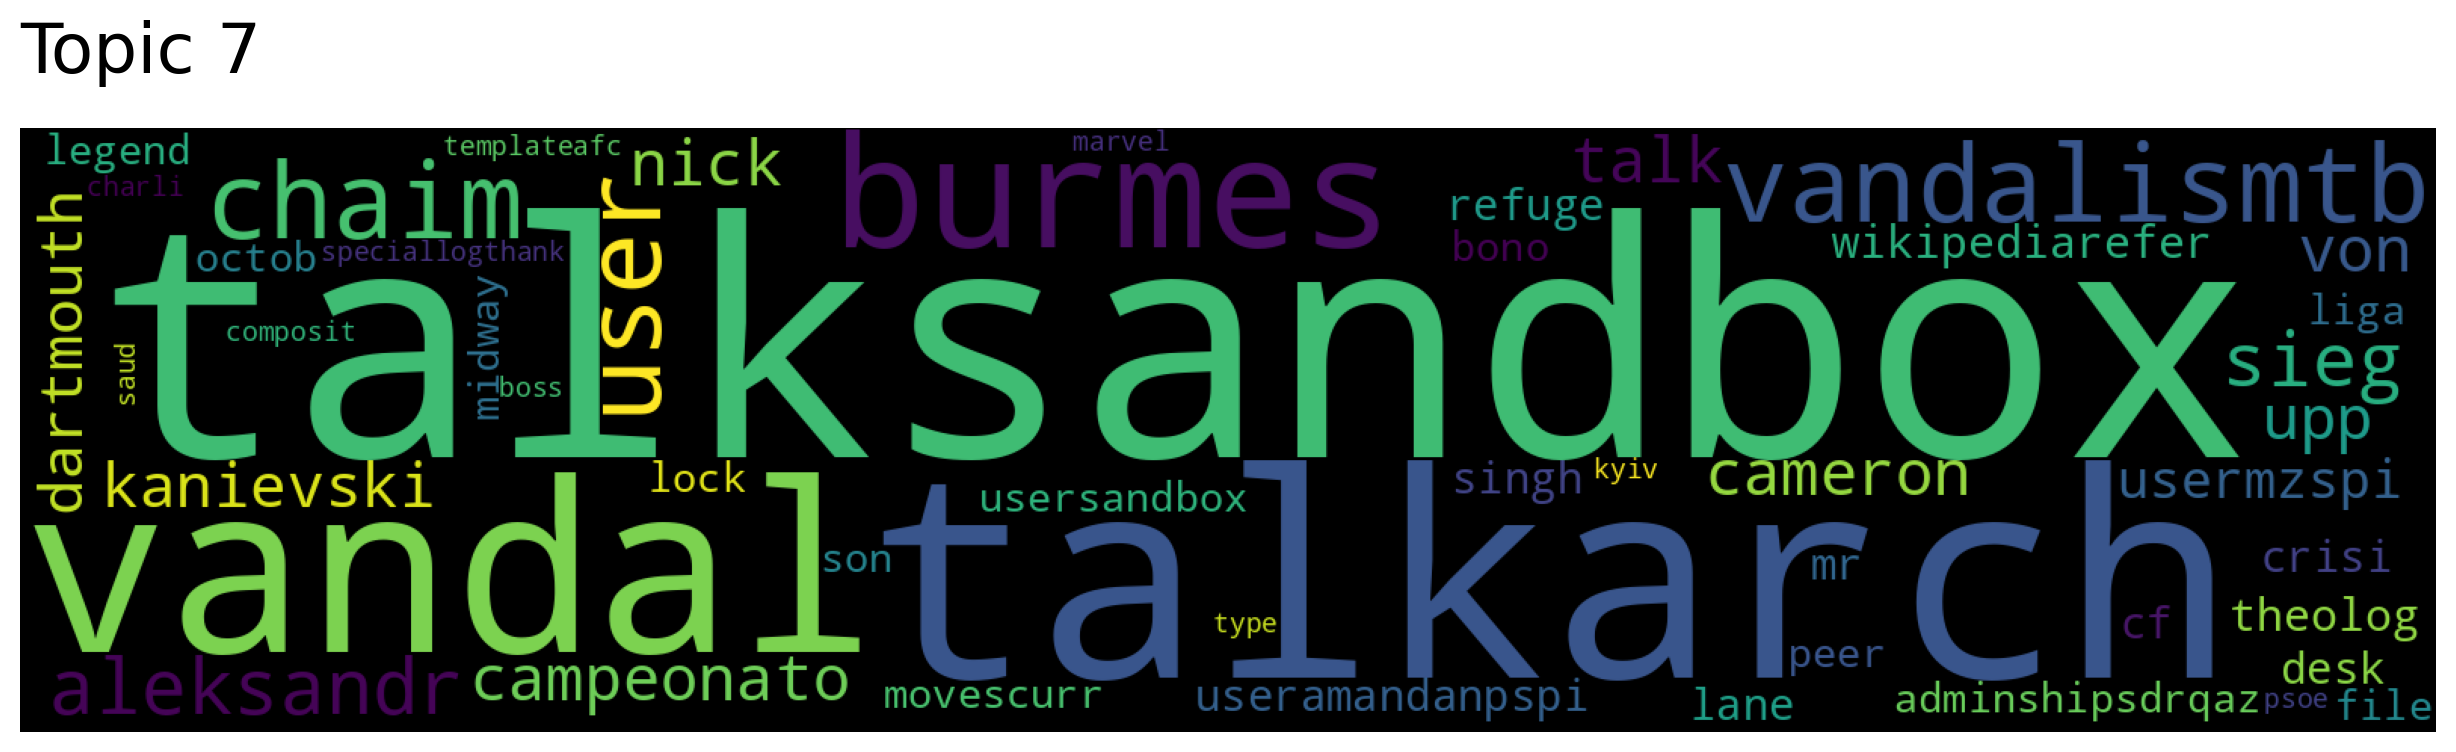

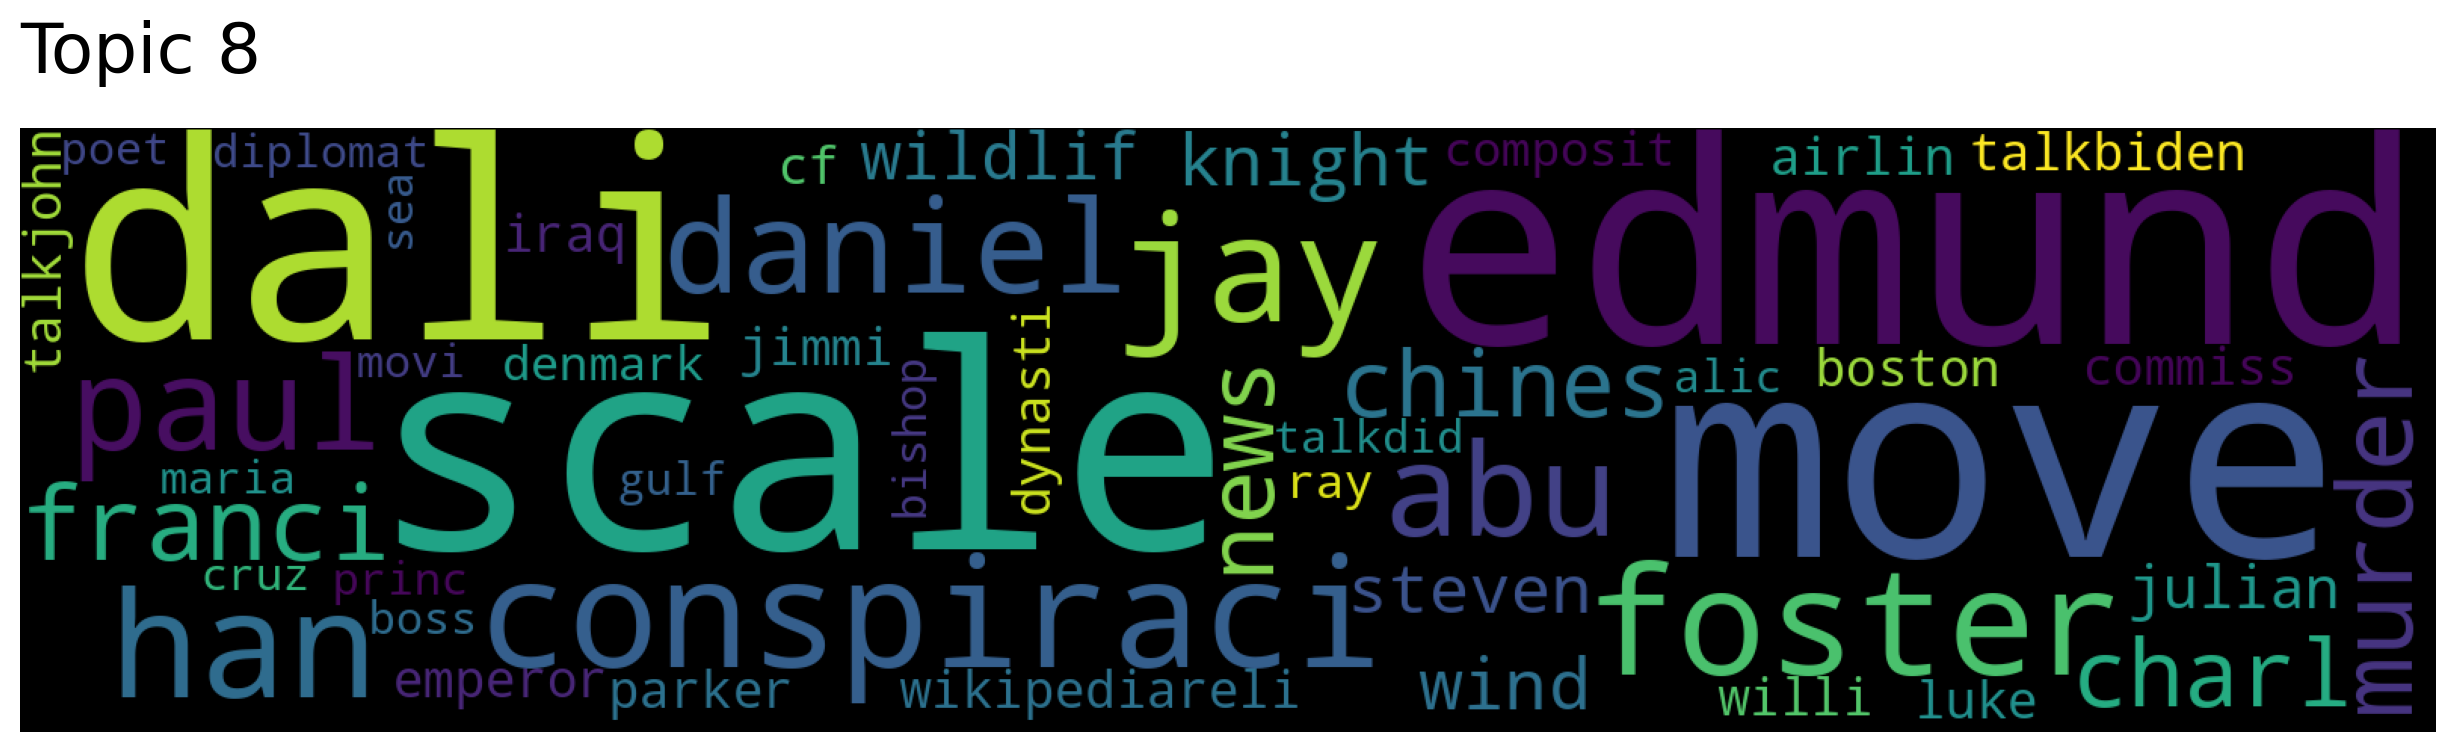

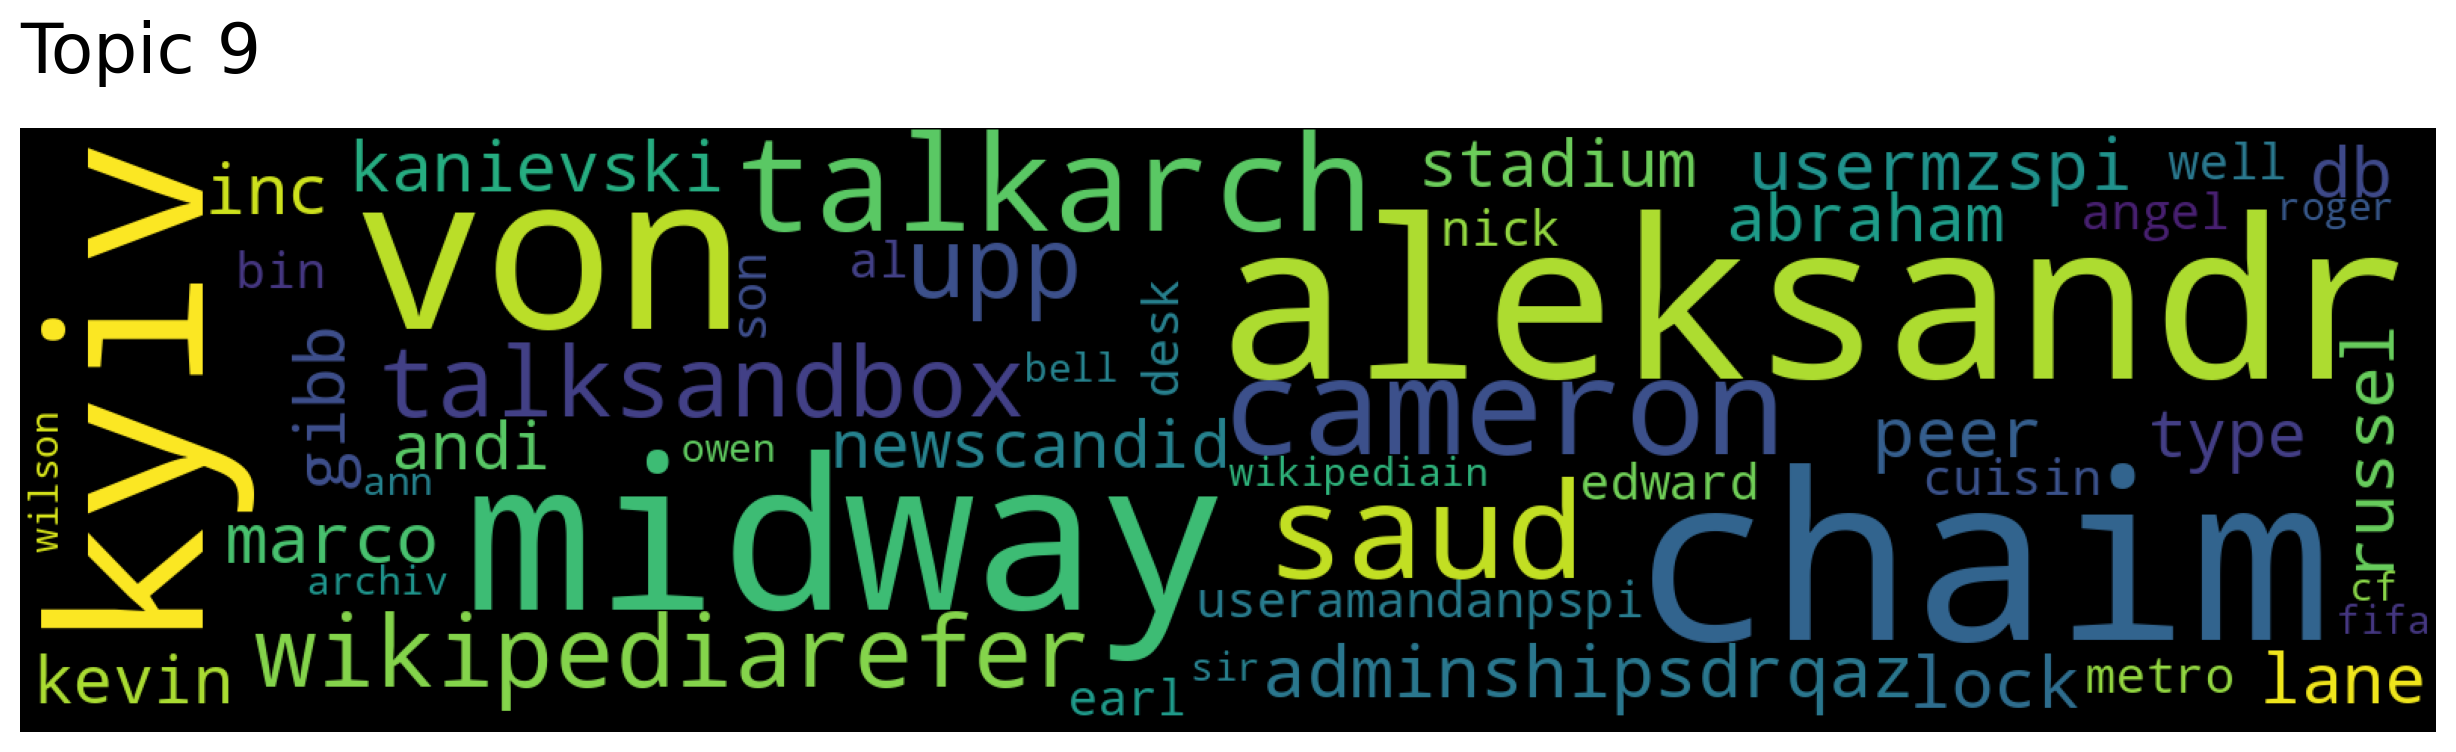

In [19]:
for topic_num in range(model.get_num_topics(reduced = True)):
    model.generate_topic_wordcloud(topic_num, background_color="black", reduced=True)